In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import decomposition
from sklearn.externals import joblib
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from catboost import CatBoostClassifier, Pool, CatBoost

In [9]:
def cleanSet(df, isTest=False):
    df.drop(['hasDayMonth'], axis=1, inplace=True)
    if isTest:
        columnsToDrop = ['CustomerInterest', 'PredictionIdx']
    else:
        columnsToDrop = ['CustomerInterest']
        y = df['CustomerInterest'].values

    df.drop(columnsToDrop, axis=1, inplace=True)

    if isTest:
        return df
    else:
        return df, y

def prepareDataSets(isTest=False):
    df_train = pd.read_csv('trade_.csv')
    df_train.sort_values(['week', 'CustomerIdx', 'IsinIdx', 'BuySell'], inplace=True)
    df_train = df_train[df_train['week'] >= 90]
    week_train = df_train['week']
    df_train.drop(['week'], axis=1, inplace=True)
    df_train['week'] = week_train.values
    del week_train

    if isTest:
        df_test = pd.read_csv('test_.csv')
        X_test = cleanSet(df_test, True)
        X_train, y_train = cleanSet(df_train)
        return X_train, y_train, X_test
    else:
        df_val = pd.read_csv('val_.csv')
        X_val, y_val = cleanSet(df_val)
        df_train = df_train[df_train['week'] < 120]
        X_train, y_train = cleanSet(df_train)
        return X_train, y_train, X_val, y_val

In [10]:
isTest = True

if isTest:
    X_train, y_train, X_val = prepareDataSets(isTest)
    print(X_train.shape, y_train.shape, X_val.shape)
else:
    X_train, y_train, X_val, y_val = prepareDataSets()
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(2164363, 19) (2164363,) (484758, 19)


In [11]:
%%time
column_description_vector = ['numeric'] * X_train.shape[1]
cat_features = list(range(0, X_train.shape[1]))
del cat_features[18]
del cat_features[13]
for x in cat_features[:]:
    column_description_vector[x] = 'factor'
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]
CPU times: user 196 µs, sys: 10 µs, total: 206 µs
Wall time: 165 µs


In [12]:
%%time
cat_train = Pool(X_train, y_train, cat_features, column_description=column_description_vector)
if isTest:
    cat_val = Pool(X_val, cat_features=cat_features, column_description=column_description_vector)
else:
    cat_val = Pool(X_val, y_val, cat_features, column_description=column_description_vector)

CPU times: user 42.6 s, sys: 847 ms, total: 43.4 s
Wall time: 46.2 s


In [13]:
params = {'iterations':100, 'learning_rate':0.15, 'depth':6, 'loss_function':'Logloss', 'eval_metric':'AUC',
         'one_hot_max_size':255, 'l2_leaf_reg':4, 'random_seed':13}

it = 3
aucs = []
preds = [0.0] * len(X_val)
seed = 13

for x in range(0,it):
    print("It: " + str(x))
    model = CatBoost(params)
    params['random_seed'] = seed
    print("Seed: " + str(seed))
    seed = seed + 15
    model.fit(cat_train)

    pred = model.predict(cat_val, prediction_type='Probability')
    preds = np.sum([preds, pred[:,1]], axis=0)

    if not isTest:
        auc = roc_auc_score(y_val, pred[:,1])
        aucs = np.append(aucs, auc)
        print("AUC: " + str(aucs))

if not isTest:
    meanAucs = np.mean(aucs)
    print("Mean AUC: " + str(meanAucs))

It: 0
Seed: 13
0:	learn: 0.7877674	total: 2.12s	remaining: 3m 30s
1:	learn: 0.7979553	total: 4s	remaining: 3m 16s
2:	learn: 0.8001573	total: 6.11s	remaining: 3m 17s
3:	learn: 0.8100601	total: 8.16s	remaining: 3m 15s
4:	learn: 0.8148974	total: 10.4s	remaining: 3m 18s
5:	learn: 0.8354932	total: 12.3s	remaining: 3m 12s
6:	learn: 0.8435288	total: 14.1s	remaining: 3m 7s
7:	learn: 0.8489713	total: 15.9s	remaining: 3m 2s
8:	learn: 0.8514645	total: 17.8s	remaining: 2m 59s
9:	learn: 0.8532595	total: 19.8s	remaining: 2m 58s
10:	learn: 0.8562211	total: 22s	remaining: 2m 58s
11:	learn: 0.8575070	total: 23.9s	remaining: 2m 55s
12:	learn: 0.8586903	total: 25.7s	remaining: 2m 51s
13:	learn: 0.8631631	total: 28.1s	remaining: 2m 52s
14:	learn: 0.8652620	total: 30.4s	remaining: 2m 52s
15:	learn: 0.8678870	total: 32.6s	remaining: 2m 50s
16:	learn: 0.8685941	total: 34.4s	remaining: 2m 47s
17:	learn: 0.8698008	total: 36.5s	remaining: 2m 46s
18:	learn: 0.8709652	total: 38.9s	remaining: 2m 45s
19:	learn: 0.8

58:	learn: 0.9215161	total: 2m 14s	remaining: 1m 33s
59:	learn: 0.9235790	total: 2m 16s	remaining: 1m 31s
60:	learn: 0.9239493	total: 2m 19s	remaining: 1m 28s
61:	learn: 0.9246206	total: 2m 21s	remaining: 1m 26s
62:	learn: 0.9248071	total: 2m 23s	remaining: 1m 24s
63:	learn: 0.9261681	total: 2m 26s	remaining: 1m 22s
64:	learn: 0.9266712	total: 2m 28s	remaining: 1m 19s
65:	learn: 0.9268430	total: 2m 30s	remaining: 1m 17s
66:	learn: 0.9272770	total: 2m 33s	remaining: 1m 15s
67:	learn: 0.9289350	total: 2m 35s	remaining: 1m 13s
68:	learn: 0.9292483	total: 2m 37s	remaining: 1m 10s
69:	learn: 0.9294677	total: 2m 40s	remaining: 1m 8s
70:	learn: 0.9300514	total: 2m 43s	remaining: 1m 6s
71:	learn: 0.9302960	total: 2m 45s	remaining: 1m 4s
72:	learn: 0.9305403	total: 2m 47s	remaining: 1m 1s
73:	learn: 0.9309868	total: 2m 49s	remaining: 59.6s
74:	learn: 0.9316127	total: 2m 52s	remaining: 57.4s
75:	learn: 0.9323858	total: 2m 54s	remaining: 55.2s
76:	learn: 0.9326291	total: 2m 57s	remaining: 52.9s
7

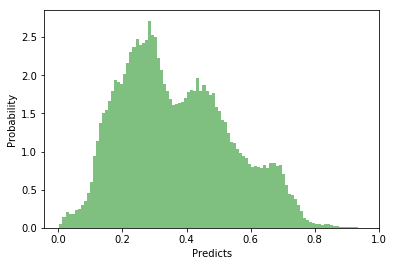

In [14]:
meanPreds = preds / it
num_bins = 100
n, bins, patches = plt.hist(meanPreds, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.xlabel('Predicts')
plt.ylabel('Probability')
plt.show()

In [15]:
if isTest:
    sub_file = pd.read_csv('sample_submission.csv')
    sub_file['CustomerInterest'] = meanPreds
    sub_file.to_csv('nando_cat_boost_003.csv', sep=',', index=False)